In [33]:
import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

#### Reading data

In [2]:
uc_games_df_joined = pd.read_pickle('../data/uc_games_df_clean')

### Modeling Approach

For our modeling approach, we will first construct a simple linear model. Because the data is small, we are very concerned with model over-fitting - using a simple model is the best approach to combat over-fitting.

https://towardsdatascience.com/7-tips-for-dealing-with-small-data-7ffbd3d399a3

https://hackernoon.com/7-effective-ways-to-deal-with-a-small-dataset-2gyl407s

Since it is a multivariate linear model, we need to check for assumptions of linearity:

1. Linear relationship
2. Multivariate normality
3. No or little multicollinearity
4. No auto-correlation
5. Homoscedasticity

We likely will not meet these assumptions purely due to the small data size.

Our explanatory variables are:
1. `software`
2. `wiki_content` (using NLP)
3. New variable for whether the developer and publisher are the same company. This is of interest since it is indicative of a large company which released the game.

In [3]:
### Define third variable above for if publisher and developer are same company
# 1 if they match, 0 if they are different
uc_games_df_joined['pub_dev_same'] = np.where(uc_games_df_joined['developer']==uc_games_df_joined['publisher'], 1, 0)

In [4]:
### Quickly examine the value counts for pub_dev_same:
uc_games_df_joined['pub_dev_same'].value_counts().to_frame()

,pub_dev_same
1,18
0,17


We see that there is a pretty fair split in `pub_dev_same`

In [5]:
uc_games_df_joined.head(2)

,game_name,uc_game_link,uc_threads,uc_posts,wiki_content,software,developer,publisher,wiki_content_length,pub_dev_same
0,arma series,https://www.unknowncheats.me/forum/arma-series...,995.0,15274.5,arma sometimes stylised as arma is a series of...,battleye,bohemia interactive,bohemia interactive,3061,1
1,all points bulletin,https://www.unknowncheats.me/forum/all-points-...,1362.0,27077.0,apb all points bulletin is an open world multi...,battleye,little orbit,little orbit,10855,1


#### Linear Relationship

Since `software` and `pub_dev_same` are categorical, we do not need to test for linearity.

Source: https://365datascience.com/question/how-do-dummy-variables-meet-the-linearity-assumption/

#### Multivariate normality

Since `software` and `pub_dev_same` are categorical, the data is not "normal" (checking for normality of nominal data does not make sense).

Source: software and pub_dev_same are categorical, w

#### No or little multicollinearity

We will not examine multicollinearity since we only have categorical variables

#### No auto-correlation

Since we do not have time series data, assume there is no auto-correlation

#### Homoscedasticity
(this will be addressed by the residuals vs. fits plot at the end of the page)

### Model

Since the data is small, our random seed and train-test split matter a lot. In this case, we will alter the random state to make is such that the `pub_dev_same` and our `y` are about even.

source: https://towardsdatascience.com/7-tips-for-dealing-with-small-data-7ffbd3d399a3

In [6]:
# defining X and y
X = uc_games_df_joined.drop(columns=['uc_posts', 'game_name', 'uc_game_link', 'uc_threads', 'developer', 'publisher', 'wiki_content_length'])
y = uc_games_df_joined['uc_posts']

In [7]:
# train test split the data
# we make sure to use stratify as it is a small dataset
# note: cannot use stratify because I don't have sufficient class labels of one of your classes to keep the data splitting ratio equal to test_size
# source: https://github.com/davidsbatista/text-classification/issues/1

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=5, 
                                                    test_size=0.2)

In [8]:
# saving index
train_index = y_train.index
test_index = y_test.index

In [9]:
# check that pub_dev_same is ~50% 
X_train['pub_dev_same'].value_counts().to_frame()

,pub_dev_same
0,14
1,14


In [10]:
# check y distribution
y_train.mean(), y_test.mean()

(36611.3231292517, 35986.031746031746)

Next we separate the wiki_content as we have to use NLP on it:

In [11]:
# train
X_train_nlp = X_train[['wiki_content']]
X_train_other = X_train[['software', 'pub_dev_same']]

# test
X_test_nlp = X_test[['wiki_content']]
X_test_other = X_test[['software', 'pub_dev_same']]

### NLP

We use NLP for `wiki_content`

First we lemmatize and remove stop words from the wiki entries (using nltk):

In [12]:
def get_relevant_lemmas(text):
    '''
    This function takes in a string of text and returns that same string
    with all english stop words removed and all remaining words lemmatized.
    
    Parameters
    ----------
    text: A string of english text.
    
    Returns
    -------
    A lemmatized string of english text with no stop words.
    '''
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    return " ".join([lemmatizer.lemmatize(word) for word in text.split() if not word.lower() in stop_words])

# note: this is a function from Bruno Barreto we used together for our group project

In [13]:
# lemmatize and remove stop words
X_train_nlp_lemmatized = X_train_nlp.applymap(get_relevant_lemmas)
X_test_nlp_lemmatized = X_test_nlp.applymap(get_relevant_lemmas)

#### TFIDF

We use tfidf as we have a wiki content length range from 3,061 to 51,900

In [14]:
uc_games_df_joined['wiki_content_length'].min(), uc_games_df_joined['wiki_content_length'].max()

(3061, 51900)

In [15]:
# define tfidf instance
tfidf = TfidfVectorizer()
# fit to train
tfidf.fit(X_train_nlp_lemmatized['wiki_content'])
# transform X_train and make dataframe
X_train_nlp_tfidf = pd.DataFrame(tfidf.transform(X_train_nlp_lemmatized['wiki_content']).todense(), columns=tfidf.get_feature_names_out())
# transform X_test and make dataframe
X_test_nlp_tfidf = pd.DataFrame(tfidf.transform(X_test_nlp_lemmatized['wiki_content']).todense(), columns=tfidf.get_feature_names_out())

In [16]:
# look at shape
X_train_nlp_tfidf.shape, X_test_nlp_tfidf.shape

((28, 8819), (7, 8819))

#### One-Hot Encoder

Next we use one-hot encoder to encode `software` and `pub_dev_same` since they are categorical

In [18]:
ct = ColumnTransformer([('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'), 
                                    ['software', 'pub_dev_same'])], 
                                  verbose_feature_names_out = False)
ct.fit(X_train_other)
X_train_other_ohe = pd.DataFrame(ct.transform(X_train_other).todense(), columns=ct.get_feature_names_out())
X_test_other_ohe = pd.DataFrame(ct.transform(X_test_other).todense(), columns=ct.get_feature_names_out())

In [19]:
X_test_other_ohe.sum()

software_defense matrix      0.0
software_easy anti-cheat     2.0
software_equ8                0.0
software_fairfight           0.0
software_none                0.0
software_punkbuster          3.0
software_ricochet            0.0
software_valve anti-cheat    0.0
software_vanguard            0.0
software_xigncode3           0.0
pub_dev_same_1               4.0
dtype: float64

We see from the warning that the transformation on the training set did not find all categories because of the small data size. We proceed and keep this in mind as it is expected with the small data size.

Combining back the data

In [20]:
# Combining datasets
X_train_preprocessed = pd.concat([X_train_nlp_tfidf, X_train_other_ohe], axis=1)
X_test_preprocessed = pd.concat([X_test_nlp_tfidf, X_test_other_ohe], axis=1)

In [21]:
X_train_preprocessed.shape, X_test_preprocessed.shape

((28, 8830), (7, 8830))

### Linear Regression

Next, we perform a linear regression on the data. We choose linear regression because our data is prone to having overfit models due to its small size, so simple models are better. Furthermore, we want interpretable results for our problem statement.

In [22]:
# instantiate linear regression
lr = LinearRegression()
# fit to encoded training data
lr.fit(X_train_preprocessed, y_train)

LinearRegression()

In [23]:
base_1 = [y_train.mean()] * len(y_test)
r2_score(y_test, base_1)

-9.610316694974586e-05

In [24]:
y_train.mean()

36611.3231292517

In [25]:
# check cross_val_score
cross_val_score(lr, X_train_preprocessed, y_train).mean().round(3)

-46.884

In [26]:
# check r-squared for train and test
lr.score(X_train_preprocessed, y_train).round(10), lr.score(X_test_preprocessed, y_test).round(3)

(1.0, -0.35)

In [27]:
y.mean()

36486.26485260771

* Since the train score is 1 and the test score is negative, we have a horrible, overfit model
* The cross_val_score is negative, further signifying a horrible model
* The r-squared for our baseline is 0. With a negative cross-val-score and negative test score, we can conclusively say the model is horrible without even comparing to the baseline.

As expected, the dataset is far too small for a linear regression. Several train-test split sizes and random states were tested as this is another method to overcome the challenge of working with small datasets - however, the results were similarly horrible for each iteration. We try to address this in the next notebook.

For now, we look at the residual vs. fits plot:

In [28]:
# calculate residuals by creating predictions for training set
preds = lr.predict(X_train_preprocessed)
resid = y_train - preds

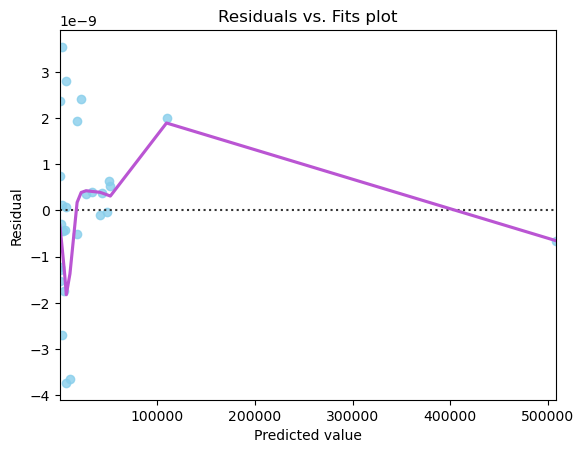

In [29]:
# create residual plot
sns.residplot(x = preds,
              y = resid,
              lowess = True,
              line_kws = {'color' : 'mediumorchid'}, color='skyblue')\
    .set(title = 'Residuals vs. Fits plot',
        xlabel = 'Predicted value',
        ylabel = 'Residual');

The residual vs. fits plot shows the assumption of homoscedasticity is violated, especially around small values for y, where there is a high spread of residuals. Again it shows that the dataset is limited and a linear regression is not a viable model.

We will not interpret the model coefficients because it is a bad model.

### Data Export

In [30]:
# add index back to y
y_train_df = pd.DataFrame(y_train, columns = ['uc_posts'])
y_train_df.insert(loc=0, column='game_id', value=train_index)

y_test_df = pd.DataFrame(y_test, columns = ['uc_posts'])
y_test_df.insert(loc=0, column='game_id', value=test_index)

In [31]:
# add index back to x
X_train_preprocessed.insert(loc=0, column='game_id', value=train_index)
X_test_preprocessed.insert(loc=0, column='game_id', value=test_index)

In [32]:
# save train and test data
X_train_preprocessed.to_pickle('../data/X_train_preprocessed')
X_test_preprocessed.to_pickle('../data/X_test_preprocessed')
y_train.to_pickle('../data/y_train')
y_test.to_pickle('../data/y_test')